In [1]:
# Enable autoreload of local Python modules (e.g., models)
# %load_ext autoreload
# %autoreload 2

In [2]:
# !git clone https://github.com/alexxthiery/char_transformer.git
# !git clone --branch sinusoidal --single-branch https://github.com/BenjaminNgJL/dsa4212_assignment.git

!git clone https://github.com/BenjaminNgJL/dsa4212_assignment.git

Cloning into 'dsa4212_assignment'...
remote: Enumerating objects: 55, done.
remote: Counting objects: 100% (55/55), done.
remote: Compressing objects: 100% (49/49), done.
remote: Total 55 (delta 12), reused 11 (delta 2), pack-reused 0 (from 0)
Receiving objects: 100% (55/55), 525.83 KiB | 8.76 MiB/s, done.
Resolving deltas: 100% (12/12), done.


In [3]:
# %cd char_transformer
%cd dsa4212_assignment
!git checkout simwei

/content/dsa4212_assignment
Branch 'simwei' set up to track remote branch 'simwei' from 'origin'.
Switched to a new branch 'simwei'


In [4]:
!ls models

models_with_pe.py  __pycache__


In [5]:
import os
import requests
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import numpy as np
import jax
import jax.numpy as jnp
import optax
import time

import flax.linen as nn
from flax.linen import attention as attn

import sys
sys.path.append('/content/dsa4212_assignment')

# local imports
import models.models_with_pe as models
# import util.generation as generation



In [6]:
!git clone https://github.com/alexxthiery/char_transformer.git
%cd char_transformer

import util.generation as generation

Cloning into 'char_transformer'...
remote: Enumerating objects: 20, done.
remote: Counting objects: 100% (3/3), done.
remote: Total 20 (delta 2), reused 2 (delta 2), pack-reused 17 (from 1)
Receiving objects: 100% (20/20), 30.14 MiB | 6.82 MiB/s, done.
Resolving deltas: 100% (3/3), done.
/content/dsa4212_assignment/char_transformer


In [7]:
# initialize the jax random key
key = jax.random.key(0)

# Load data

In [8]:
test_url = "https://raw.githubusercontent.com/alexxthiery/char_transformer/afa30c8b3c2be8a40a96bdffd26da54e874e06de/data/text8_test.txt"
train_url = "https://raw.githubusercontent.com/alexxthiery/char_transformer/afa30c8b3c2be8a40a96bdffd26da54e874e06de/data/text8_train.txt"

# Download test data
test_text = requests.get(test_url).text
train_text = requests.get(train_url).text

print(test_text[:100])  # preview

be ejected and hold it there examine the chamber to ensure it is clear allow the action to go forwar


In [9]:
# load the ./data/text8_train.txt and ./data/text8_test.txt files
# with open("./data/text8_train.txt", "r") as f:
#     train_text = f.read()
# with open("./data/text8_test.txt", "r") as f:
#     test_text = f.read()

# print the length of the training text and test text
print(f"Length of training text: {len(train_text):_} characters")
print(f"Length of test text: {len(test_text):_} characters")

Length of training text: 90_000_000 characters
Length of test text: 5_000_000 characters


In [10]:
# Build vocabulary (lowercase + space + a few punctuations)
char_set = list("abcdefghijklmnopqrstuvwxyz ")
char_to_int = {ch:i for i,ch in enumerate(char_set)}
int_to_char = {i:ch for ch,i in char_to_int.items()}

def encode(s):
    """Encode string to array of integers"""
    ids = [char_to_int[c] for c in s]
    return np.array(ids, dtype=np.uint8)  # use np.uint8 to save space

In [11]:
# encode the text
train_text_int = encode(train_text)
test_text_int = encode(test_text)

In [12]:
# sanity check: display a few random characters from the training text
T = 128
for _ in range(5):
    # choose random position in text
    N = np.random.randint(low=0, high=len(train_text)-T)
    print(train_text[N:N+T])
    print()

usually have traffic lights but expressways may in places where this distinction is made gallery of design features signage for 

ere parerga and paralipomena volume i fragments for the history of philosophy seven malebranche malebranche disagreed that if th

ight two zero zero five an untitled seven minute mini episode set in the immediate aftermath of the parting of the ways and lead

ses the tao romanization such as taoism and tao te ching in all articles external links http www truetao org laotzu taote guide 

ree seven the cpr acquired its first diesel electric locomotive a custom built one of a kind switcher numbered seven zero zero z



# Create a basic Transformer model

In [13]:
def create_train_state(rng, vocab_size, d_model, n_layers, n_heads,
                       max_len, pos_encoding):
    # create a basic Transformer model
    model = models.DecoderOnlyTransformer(
        vocab_size=vocab_size,
        d_model=d_model,
        n_layers=n_layers,
        n_heads=n_heads,
        max_len=max_len,
        pos_encoding=pos_encoding
    )
    # (sinusoidal, learned, rotary)

    # create a dummy input for initialization
    dummy = jnp.zeros((1, min(16, max_len)), dtype=jnp.int32)
    # pass the dummy input to the model to initialize the parameters
    params = model.init({"params": rng}, dummy)["params"]

    return model, params

In [14]:
# vocab size
vocab_size= len(char_set)

# internal model dimensions
d_model=256

# number of attention heads
n_heads=8

# number of Transformer layers
n_layers= 4

# maximum sequence length
max_len=128

# positional encoding type
pos_encoding = "learned"

model, params = create_train_state(key, vocab_size, d_model, n_layers, n_heads, max_len, pos_encoding)

In [15]:
# compute the number of parameters
def count_params(params):
    return sum(x.size for x in jax.tree_util.tree_leaves(params))
print(f"Number of parameters: {count_params(params):_}")

Number of parameters: 3_202_048


In [16]:
# sanity check: create a batch of data & run a forward pass
B, T = 4, 32
batch = jax.random.randint(
    key=key,
    shape=(B, T), minval=0, maxval=len(char_set))
logits = model.apply({"params": params}, batch)

print("batch shape:", batch.shape)  # (B, T)
print("logits shape:", logits.shape)  # (B, T, vocab_size)

batch shape: (4, 32)
logits shape: (4, 32, 27)


# Loss function

In [17]:
# 1) cross-entropy
def loss_ce(logits, targets):
    """
    Standard cross-entropy loss with accuracy metrics.
    """
    vocab = logits.shape[-1]
    flat_logits  = logits.reshape(-1, vocab)   # (N, V)
    flat_targets = targets.reshape(-1)         # (N,)

    per_pos = optax.softmax_cross_entropy_with_integer_labels(flat_logits, flat_targets)
    loss = per_pos.mean()

    preds = jnp.argmax(logits, axis=-1)  # (B, T)
    is_match = preds == targets

    acc_all  = jnp.mean(is_match.astype(jnp.float32))
    acc_last = jnp.mean(is_match.astype(jnp.float32)[:, -1])

    return loss, {"loss": loss, "acc": acc_all, "acc_last": acc_last}


# 2) Label-smoothed cross-entropy
def loss_label_smooth(logits, targets, epsilon=0.1):
    """Compute label-smoothed cross-entropy loss and accuracy."""
    vocab = logits.shape[-1]

    log_probs = jax.nn.log_softmax(logits, axis=-1)           # (B, T, V)
    targets_onehot = jax.nn.one_hot(targets, vocab)          # (B, T, V)

    smoothed_targets = (1.0 - epsilon) * targets_onehot + epsilon / vocab
    loss = -jnp.sum(smoothed_targets * log_probs, axis=-1).mean()

    preds = jnp.argmax(logits, axis=-1)
    is_match = preds == targets
    acc_all  = jnp.mean(is_match.astype(jnp.float32))
    acc_last = jnp.mean(is_match.astype(jnp.float32)[:, -1])

    return loss, {"loss": loss, "acc": acc_all, "acc_last": acc_last}


# 3) Focal loss (for sequence modelling)
def loss_focal(logits, targets, gamma: float = 2.0, alpha: float | None = None):
    """
    Focal loss for sequence modelling.
    Args:
      logits: (B, T, V)
      targets: (B, T)
    """
    B, T, V = logits.shape

    log_probs = jax.nn.log_softmax(logits, axis=-1)  # (B, T, V)
    probs     = jnp.exp(log_probs)                   # (B, T, V)

    targets_exp = targets[..., None]                 # (B, T, 1)
    p_t     = jnp.take_along_axis(probs,     targets_exp, axis=-1).squeeze(-1)     # (B, T)
    log_p_t = jnp.take_along_axis(log_probs, targets_exp, axis=-1).squeeze(-1)     # (B, T)

    focal_factor = (1.0 - p_t) ** gamma             # (B, T)

    if alpha is not None:
        alpha_t   = jnp.full_like(p_t, alpha)
        focal_loss = -alpha_t * focal_factor * log_p_t
    else:
        focal_loss = -focal_factor * log_p_t

    loss = focal_loss.mean()

    preds = jnp.argmax(logits, axis=-1)
    is_match = preds == targets
    acc_all  = jnp.mean(is_match.astype(jnp.float32))
    acc_last = jnp.mean(is_match.astype(jnp.float32)[:, -1])

    return loss, {"loss": loss, "acc": acc_all, "acc_last": acc_last}


In [18]:
def loss_ls_0_1(logits, targets):
    return loss_label_smooth(logits, targets, epsilon=0.1)

def loss_focal_default(logits, targets):
    return loss_focal(logits, targets, gamma=2.0, alpha=None)

losses_to_test = [
    ("cross_entropy",    loss_ce),
    ("label_smoothing",  loss_ls_0_1),
    ("focal",            loss_focal_default),
]


# Select baseline model for the 3-loss experiment

baseline_model_name  = "256d_8h_baseline"
baseline_model       = model
baseline_params_init = params

In [19]:
# @jax.jit
# ### cross_entropy
# def loss_and_metrics(logits, targets):
#     """Compute cross-entropy loss and accuracy.

#     Assumes `targets` contains only valid integer class ids in [0, V-1] (no -1 ignore tokens).

#     Args:
#       logits: (B, T, V) float array of unnormalized scores.
#       targets: (B, T) integer array with ground-truth class ids.

#     Returns:
#       loss: scalar average cross-entropy over all positions.
#       metrics: dict with keys "loss" and "acc" (both scalars).
#     """
#     # Flatten batch/time dims so optax works on shape (N, V) and (N,)
#     vocab = logits.shape[-1]
#     flat_logits = logits.reshape(-1, vocab)
#     flat_targets = targets.reshape(-1)

#     # Per-position cross-entropy, then mean over all positions
#     per_pos = optax.softmax_cross_entropy_with_integer_labels(flat_logits, flat_targets)
#     loss = per_pos.mean()

#     # prediction over all positions
#     preds = jnp.argmax(logits, axis=-1)  # (B, T)

#     # compute accuracy over only the last position
#     is_match = preds == targets

#     # Accuracy over all positions
#     acc_all = jnp.mean(is_match.astype(jnp.float32))

#     # Accuracy over only last position
#     acc_last = jnp.mean(is_match.astype(jnp.float32)[:,-1])

#     return loss, {"loss": loss, "acc": acc_all, "acc_last": acc_last}

In [20]:
# @jax.jit
# #  label-smoothed cross-entropy

# def loss_and_metrics(logits, targets, epsilon=0.1):
#     """Compute label-smoothed cross-entropy loss and accuracy."""
#     vocab = logits.shape[-1]

#     # Compute log-probabilities
#     log_probs = jax.nn.log_softmax(logits, axis=-1)  # (B, T, V)

#     # One-hot encode targets
#     targets_onehot = jax.nn.one_hot(targets, vocab)  # (B, T, V)

#     # Apply label smoothing:
#     # q_i = (1 - ε) * one_hot + ε / V
#     smoothed_targets = (1 - epsilon) * targets_onehot + epsilon / vocab

#     # Cross-entropy: mean over batch and time
#     loss = -jnp.sum(smoothed_targets * log_probs, axis=-1).mean()

#     # Accuracy metrics
#     preds = jnp.argmax(logits, axis=-1)
#     is_match = preds == targets
#     acc_all = jnp.mean(is_match.astype(jnp.float32))
#     acc_last = jnp.mean(is_match.astype(jnp.float32)[:, -1])

#     return loss, {"loss": loss, "acc": acc_all, "acc_last": acc_last}


In [21]:
# ## focal loss

# @jax.jit
# def loss_and_metrics(logits, targets, gamma: float = 2.0, alpha: float | None = None):
#     """
#     Focal loss for sequence modelling.
#     Args:
#       logits: (B, T, V)
#       targets: (B, T) int in [0, V-1]
#       gamma: focusing parameter (>0 → focus more on hard tokens)
#       alpha: optional class-balancing weight. If float in (0,1), it is applied
#              to the true class. If None, no α is used.

#     Returns:
#       loss: scalar focal loss averaged over all tokens
#       metrics: dict with loss, acc (all tokens), acc_last (last token per seq)
#     """
#     B, T, V = logits.shape

#     # log p and p
#     log_probs = jax.nn.log_softmax(logits, axis=-1)   # (B, T, V)
#     probs = jnp.exp(log_probs)                        # (B, T, V)

#     # gather p_y and log p_y for the true class
#     targets_exp = targets[..., None]                  # (B, T, 1)
#     p_t = jnp.take_along_axis(probs, targets_exp, axis=-1).squeeze(-1)      # (B, T)
#     log_p_t = jnp.take_along_axis(log_probs, targets_exp, axis=-1).squeeze(-1)  # (B, T)

#     # focal term: (1 - p_t)^gamma
#     focal_factor = (1.0 - p_t) ** gamma               # (B, T)

#     # optional alpha weighting
#     if alpha is not None:
#         # α for the true class only
#         alpha_t = jnp.full_like(p_t, alpha)
#         focal_loss = -alpha_t * focal_factor * log_p_t
#     else:
#         focal_loss = -focal_factor * log_p_t          # (B, T)

#     # mean over all tokens
#     loss = focal_loss.mean()

#     # metrics (same as before)
#     preds = jnp.argmax(logits, axis=-1)               # (B, T)
#     is_match = (preds == targets)
#     acc_all = is_match.astype(jnp.float32).mean()
#     acc_last = is_match.astype(jnp.float32)[:, -1].mean()

#     return loss, {"loss": loss, "acc": acc_all, "acc_last": acc_last}


# Optimization step:

In [22]:
@jax.jit
def train_step(params, opt_state, x, y, tx, model, loss_fn):
    """Single optimisation step for the given loss function."""
    def loss_wrapper(params, x, y):
        logits = model.apply({"params": params}, x)
        loss, metrics = loss_fn(logits, y)
        return loss, metrics

    (loss, metrics), grads = jax.value_and_grad(loss_wrapper, has_aux=True)(params, x, y)
    updates, opt_state = tx.update(grads, opt_state, params)
    params = optax.apply_updates(params, updates)
    metrics["loss"] = loss
    return params, opt_state, metrics


In [23]:
# # create an update function
# def train_step(params, opt_state, x, y, tx):
#     """Single optimization step using optax optimizer.

#     Args:
#       params: pytree of model parameters.
#       opt_state: optax optimizer state corresponding to `params`.
#       x: (B, T) int array input tokens.
#       y: (B, T) int array target tokens.
#       tx: optax.GradientTransformation (already initialized).

#     Returns:
#       new_params: updated parameters after one gradient step.
#       new_opt_state: updated optimizer state.
#       metrics: dict of scalar metrics (loss, acc).
#     """
#     def loss_fn(params):
#         logits = model.apply({"params": params}, x)
#         # loss, metrics = loss_and_metrics(logits, y) #for cross_entropy
#         loss, metrics = loss_and_metrics(logits, y, epsilon=0.1) #for label smoothing cross_entropy
#         # loss, metrics = loss_and_metrics(logits, y, gamma=2.0) # for focal loss

#         return loss, metrics

#     # compute gradients (loss is scalar, metrics is auxiliary)
#     (loss, metrics), grads = jax.value_and_grad(loss_fn, has_aux=True)(params)

#     # optax update: compute parameter updates and new optimizer state
#     updates, new_opt_state = tx.update(grads, opt_state, params)
#     new_params = optax.apply_updates(params, updates)
#     return new_params, new_opt_state, metrics

# # jit: last argument should be static because it is an object
# train_step = jax.jit(train_step, static_argnames=("tx",))

# Batch creation:

In [24]:
# create a batch from the training data
def get_batch(text_int, B, T):
    """Create a random batch of data from text_int.

    Args:
      text_int: 1D array of token ids.
      B: batch size (number of sequences).
      T: sequence length (number of tokens per sequence).

    Returns:
      x: (B, T) int array input tokens.
      y: (B, T) int array target tokens.
    """
    # choose random starting indices for each sequence in the batch
    ix = np.random.randint(0, len(text_int) - T, size=B)
    # inputs are text from i to i+T
    x = np.stack([text_int[i:i+T] for i in ix])
    # targets are text from i+1 to i+T+1
    y = np.stack([text_int[i+1:i+T+1] for i in ix])
    return jnp.array(x, dtype=jnp.int32), jnp.array(y, dtype=jnp.int32)

# Optimizer creation:

In [25]:
# define optax optimizer
learning_rate = 0.001


# Create Adam optimizer (Optax)
tx = optax.adam(learning_rate=learning_rate)
# Initialize optimizer state for current params
opt_state = tx.init(params)
print(f"Initialized optimizer: Adam lr={learning_rate}")



Initialized optimizer: Adam lr=0.001


In [26]:
def train_model(model, params, opt_state, train_text_int, test_text_int,
                B, T, tx, model_name, loss_fn, max_time=180):
    """
    Train `model` with the given `loss_fn`.

    loss_fn: callable(logits, targets) -> (loss, metrics_dict)
    metrics_dict must contain keys: 'acc', 'acc_last'.
    """

    # --- Inner jitted train_step that CAPTURES loss_fn & model & tx ---
    @jax.jit
    def train_step_inner(params, opt_state, x, y):
        def loss_wrapper(params, x, y):
            logits = model.apply({"params": params}, x)
            loss, metrics = loss_fn(logits, y)
            return loss, metrics

        (loss, metrics), grads = jax.value_and_grad(loss_wrapper, has_aux=True)(params, x, y)
        updates, opt_state_new = tx.update(grads, opt_state, params)
        params_new = optax.apply_updates(params, updates)
        metrics["loss"] = loss
        return params_new, opt_state_new, metrics

    # --- Training loop (same as before, but calls train_step_inner) ---
    print(f"\nStarting training for {model_name} (max {max_time}s)...")
    time_start = time.time()
    loss_history, time_history = [], []
    loss_test_history, time_test_history = [], []
    it = 0

    while True:
        elapsed = time.time() - time_start
        if elapsed > max_time:
            print(f"Time limit reached ({elapsed:.1f}s). Stopping training.\n")
            break

        x, y = get_batch(train_text_int, B, T)
        params, opt_state, metrics = train_step_inner(params, opt_state, x, y)

        loss_history.append(metrics["loss"])
        time_history.append(elapsed)

        if it % 100 == 0 or (time.time() - time_start) % 30 < 1:
            B_test, T_test = 512, 32
            test_input, test_target = get_batch(test_text_int, B_test, T_test)
            test_logits = model.apply({"params": params}, test_input)
            test_loss, test_metrics = loss_fn(test_logits, test_target)

            loss_test_history.append(test_loss)
            time_test_history.append(elapsed)

            print(
                f"iter {it:05d} | {elapsed:6.1f}s | "
                f"loss(train/test): {metrics['loss']:.4f}/{test_loss:.4f} | "
                f"acc(train/test): {100*metrics['acc']:.1f}%/{100*test_metrics['acc']:.1f}% | "
                f"acc_last(train/test): {100*metrics['acc_last']:.1f}%/{100*test_metrics['acc_last']:.1f}%"
            )
        it += 1

    return params, opt_state, loss_history, time_history, loss_test_history, time_test_history


In [27]:
# #niter = 100_000

# niter=2_000
# B, T = 128, 32
# loss_history = []
# time_history = []
# time_test_history = []
# loss_test_history = []
# time_start = time.time()
# for it in range(niter):
#     batch = get_batch(train_text_int, B, T)
#     input, target = batch[0], batch[1]
#     params_new, opt_state_new, metrics = train_step(params, opt_state, input, target, tx)

#     # update params and opt_state
#     params = params_new
#     opt_state = opt_state_new
#     acc = metrics['acc']
#     acc_last = metrics['acc_last']
#     loss = metrics['loss']

#     loss_history.append(loss)
#     time_history.append(time.time() - time_start)

#     if it % (niter // 50) == 0 or it == niter - 1:
#         time_since_start = time.time() - time_start
#         # compute loss on test set
#         B_test, T_test = 1024, 32
#         test_batch = get_batch(test_text_int, B_test, T_test)
#         test_input, test_target = test_batch[0], test_batch[1]
#         test_logits = model.apply({"params": params}, test_input)
#         test_loss, test_metrics = loss_and_metrics(test_logits, test_target)
#         test_acc = test_metrics['acc']
#         test_acc_last = test_metrics['acc_last']
#         loss_test_history.append(test_loss)
#         time_test_history.append(time_since_start)
#         print(f"iteration {it:_}  time: {time_since_start:.1f} seconds")
#         print(f"\t \t loss(train :: test): {loss:.4f} :: {test_loss:.4f}")
#         print(f"\t \t accuracy (train :: test): {100*acc:.1f}% :: {100*test_acc:.1f}%")
#         print(f"\t \t accuracy (last character) (train :: test): {100*acc_last:.1f}% :: {100*test_acc_last:.1f}%")
#         print()


In [28]:
# # plot the loss history
# import matplotlib.pyplot as plt
# plt.plot(time_history, loss_history, '-', label='train', color="blue")
# plt.plot(time_test_history, loss_test_history, '-', label='test', lw=2, color="red")
# plt.xlabel("Time (seconds)")
# plt.ylabel("Loss")
# plt.legend(loc='upper right')
# plt.title("Training Loss History")
# plt.grid()

In [29]:
# ============================================================
# Train with 3 losses
# ============================================================

B, T = 128, 32
max_time = 180
results_loss = []

for loss_name, loss_fn in losses_to_test:
    print("\n==============================")
    print(f"Training {baseline_model_name} with loss = {loss_name}")
    print("==============================")

    params = baseline_params_init
    opt_state = tx.init(params)

    run_name = f"{baseline_model_name}_loss={loss_name}"
    params, opt_state, loss_hist, time_hist, loss_test_hist, time_test_hist = train_model(
        baseline_model,
        params,
        opt_state,
        train_text_int,
        test_text_int,
        B,
        T,
        tx,
        run_name,
        loss_fn,
        max_time=max_time,
    )

    results_loss.append({
        "name": run_name,
        "loss_name": loss_name,
        "params": params,
        "loss_history": loss_hist,
        "time_history": time_hist,
        "test_loss_history": loss_test_hist,
        "test_time_history": time_test_hist,
    })





Training 256d_8h_baseline with loss = cross_entropy

Starting training for 256d_8h_baseline_loss=cross_entropy (max 180s)...
iter 00000 |    0.0s | loss(train/test): 3.8472/4.3324 | acc(train/test): 2.5%/17.0% | acc_last(train/test): 2.3%/16.2%
iter 00100 |   12.0s | loss(train/test): 2.3823/2.3802 | acc(train/test): 28.7%/28.0% | acc_last(train/test): 23.4%/23.6%
iter 00200 |   15.0s | loss(train/test): 2.0641/2.0877 | acc(train/test): 36.5%/36.4% | acc_last(train/test): 39.1%/35.9%
iter 00300 |   18.0s | loss(train/test): 1.8976/1.8833 | acc(train/test): 42.1%/42.3% | acc_last(train/test): 40.6%/40.4%
iter 00400 |   21.0s | loss(train/test): 1.7931/1.7641 | acc(train/test): 45.4%/46.2% | acc_last(train/test): 43.8%/47.1%
iter 00500 |   24.1s | loss(train/test): 1.6998/1.6793 | acc(train/test): 48.7%/48.5% | acc_last(train/test): 44.5%/51.0%
iter 00600 |   27.2s | loss(train/test): 1.6464/1.6591 | acc(train/test): 49.5%/49.4% | acc_last(train/test): 49.2%/50.8%
iter 00692 |   30.0s |

In [30]:
# B = 1
# seed = 42
# rng = jax.random.PRNGKey(seed)
# prompt = "hello my fri"
# # prompt_int = encode(prompt.lower())
# prompt_int = jnp.array([ [char_to_int.get(c, len(char_set)) for c in prompt.lower()[:64]] ], dtype=jnp.int32)

# gen_len = 1000
# out_ids = generation.generate_tokens(model, params, rng, prompt_int, gen_len, block_size=64,
#                           temperature=0.7, sample=True)
# print('generated ids shape:', out_ids.shape)
# print('generated text:')
# generated_text = ''.join(int_to_char.get(int(x), '?') for x in list(out_ids[0]))
# # concatenate with prompt
# print(prompt + generated_text)
# #print(''.join(int_to_char.get(int(x), '?') for x in list(out_ids[0])))

In [31]:
# ============================================================
# Generate and print text for each of the 3 loss-function models
# ============================================================

B = 1
seed = 42
rng = jax.random.PRNGKey(seed)
prompt = "hello my fri"

# Encode prompt
prompt_int = jnp.array(
    [[char_to_int.get(c, len(char_set)) for c in prompt.lower()[:64]]],
    dtype=jnp.int32
)

gen_len = 1000

print("\n==============================")
print("TEXT GENERATION FOR EACH LOSS FUNCTION")
print("==============================\n")

for entry in results_loss:
    model_name = entry["name"]
    loss_name = entry["loss_name"]
    params = entry["params"]

    print(f"\n===== GENERATED TEXT — {loss_name} =====")

    out_ids = generation.generate_tokens(
        baseline_model,               # <-- USE THE SAME MODEL
        params,
        rng,
        prompt_int,
        gen_len,
        block_size=64,
        temperature=0.7,
        sample=True
    )

    generated_text = ''.join(
        int_to_char.get(int(x), '?') for x in list(out_ids[0])
    )

    print(prompt + generated_text)
    print("=" * 80)



TEXT GENERATION FOR EACH LOSS FUNCTION


===== GENERATED TEXT — cross_entropy =====
hello my fri ie s ckimo as a a sh an devinto nintwent bhnonongesin on s cha o conachien dy esues onint mexe bbe ale s t w scononadr lacaskionusthineradron beinis iche an toan ta s as a u chuselate incont t tran moningine cestis intaruredre dongle tom c ime ticlascices a ge arth f tha mans thy ales in cabe orin clunedesonale ononeimet ine man ineris d le a corsones aispen teronthe in gand bem an onguragfin weminincot wariganine a ounevia mpenis mialen achs s opane cor a ft plades lisperbisthonis indonshilasth bom hade tes ices nocanace d bu t si g aroru ron an n bbu aun wil sh gha ted f he avinsc yn it prndecl rynise rowesainele phenses anauisesane alamin t a on as as alaran m tistar ys men leronone achoterenuf inich onine twe bme ocotin lars ora bese hs wlenthrgiman wananesig mon an nshon teou ane s al wa aneskedimereranoran troureanoothon on s m es a lino athis ch in olalerestala dindst anarichecho co

In [32]:
import matplotlib.pyplot as plt

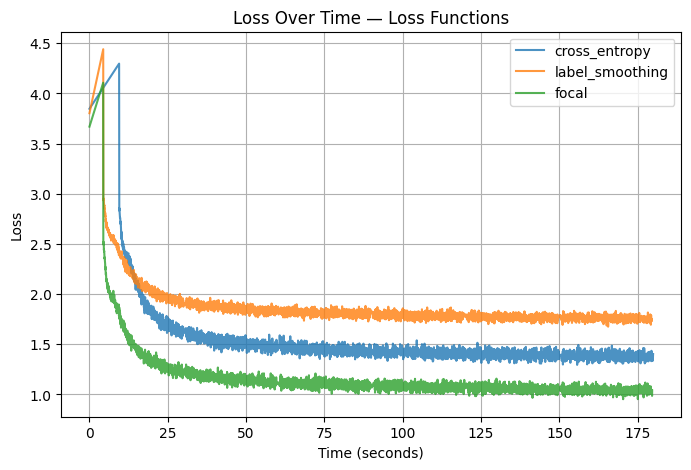

In [33]:
# os.makedirs("plots", exist_ok=True)

plt.figure(figsize=(8, 5))
plt.title("Loss Over Time — Loss Functions")
plt.xlabel("Time (seconds)")
plt.ylabel("Loss")
plt.grid(True)
for r in results_loss:
    plt.plot(r["time_history"], r["loss_history"], label=r["loss_name"], alpha=0.8)
plt.legend()
plt.show()
# out_path = "plots/loss_fn_comparison_over_time.png"
# plt.savefig(out_path, bbox_inches="tight")
# plt.close()
# print(f" Saved plot: {out_path}")
